
Практика 1: Исследование атак на модели ИИ. Fast
Gradient Sign Method (FGSM)

Белов Владимир Станиславович ББМО-01-23

**Цель задания:**
Познакомиться с одной из популярных атак на системы машинного обучения — атакой Fast Gradient
Sign Method (FGSM). Задача — научиться использовать FGSM для создания противоречивых (adversarial)
примеров, которые могут ввести обученную модель в заблуждение

**Задачи:**
1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы FGSM.
3. Реализовать атаку FGSM и сгенерировать противоречивые примеры.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных
данных.



**Шаг 1:** Загрузим обученные модели и данных MNIST
из предыдущей практики для далшьнейшего анализа.


In [12]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')
# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9751 - loss: 0.0808
Test accuracy on clean images: 0.9779999852180481


**Шаг 2:** Теория FGSM и реализация атаки FGSM.

Атака Fast Gradient Sign Method (FGSM) — это метод генерации противоречивых примеров, который
изменяет пиксели изображения на минимальные величины, направленные на ухудшение предсказаний
модели. FGSM использует градиент потерь по отношению к входному изображению и добавляет
небольшие изменения, чтобы максимизировать ошибку предсказания.
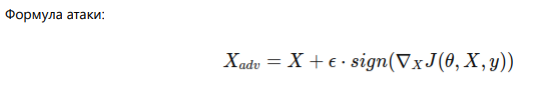

Теперь реализуем FGSM для генерации противоречивых примеров.

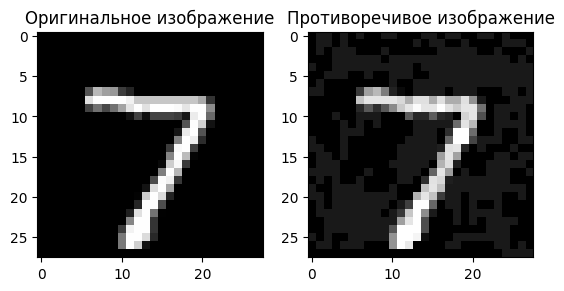

In [19]:
import numpy as np

# Функция для реализации FGSM атаки
def fgsm_attack(image, epsilon, gradient):
  # Применение знака градиента к изображению
  perturbed_image = image + epsilon * np.sign(gradient)
  # Обрезка значений, чтобы они оставались в пределах [0,1]
  perturbed_image = np.clip(perturbed_image, 0, 1)
  return perturbed_image

# Вычисление градиента
def generate_adversarial_example(model, image, label, epsilon):
    # Превращаем изображение в формат, подходящий для модели
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))
    label = tf.convert_to_tensor(label)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)

    # Получение градиента по отношению к входному изображению
    gradient = tape.gradient(loss, image)
    # Применение FGSM
    adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())

    return adversarial_image

# Пример использования
epsilon = 0.1  # Величина шума
adversarial_example = generate_adversarial_example(model, test_images[0], test_labels[0], epsilon)

# Вывод результатов
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.show()

**Шаг 3:** Оценка модели на противоречивых примерах.

Теперь мы проверим точность модели на противоречивых изображениях, сгенерированных при
помощи FGSM.


In [23]:
def generate_adversarial_dataset(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image.reshape(28, 28))
    return np.array(adversarial_images)
# Генерация противоречивых примеров
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon)
# Проверка размеров
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on a small subset of adversarial examples: {adversarial_acc}')



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0768 - loss: 7.1268
Accuracy on a small subset of adversarial examples: 0.10119999945163727


**Шаг 4:** Сравнение результатов.

В ходе работы можно заметить, как точность на обычных примерах (~97,8%) опускается до ~10,1% на противоречивых. Данная работа показывает, что легко ввести модель в заблуждение.